 # Finding the best neighborhood in Chicago
 

In [1]:
import requests
import pandas as pd
import datetime
 
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Import Chicago current crime Data Set

In [2]:
original_data=pd.read_csv("https://data.cityofchicago.org/api/views/qzdf-xmn8/rows.csv")

In [3]:
df_Chicago = original_data.copy()
df_Chicago["Date"]= pd.to_datetime(df_Chicago["Date"])
df_Chicago['Date'] = df_Chicago['Date'].dt.date
df_Chicago = df_Chicago[['Community Area', 'Date','Primary Type']]
df_Chicago_grouped = df_Chicago.groupby('Community Area').count()
df_Chicago.head(20)

,Community Area,Date,Primary Type
0,26,2020-12-07,ROBBERY
1,10,2020-11-30,DECEPTIVE PRACTICE
2,49,2020-12-08,ASSAULT
3,39,2020-12-02,DECEPTIVE PRACTICE
4,31,2020-11-28,ASSAULT
5,53,2020-12-05,BURGLARY
6,43,2020-12-10,THEFT
7,75,2020-11-28,CRIMINAL SEXUAL ASSAULT
8,40,2020-11-30,ROBBERY
9,26,2020-11-29,BATTERY


### Read the Chicago neighborhood text file 

In [4]:
Chicago_community_data = pd.read_csv('https://raw.githubusercontent.com/jkgiesler/parse-chicago-neighborhoods/master/community_to_gps.txt',sep='\t') #load chicago community geodata
Chicago_community_data.head()

,Community Area,Community Name,Latitude,Longitude
0,1,Rogers Park,42.003801,-87.657651
1,1,Rogers Park,42.002439,-87.657809
2,1,Rogers Park,41.998390,-87.657676
3,1,Rogers Park,42.009069,-87.661341
4,1,Rogers Park,42.005680,-87.660129


In [5]:
# Take the mean of latitude/longitude for each neighborhood
Chicago_community=Chicago_community_data.groupby(['Community Area','Community Name']).mean()
Chicago_community.reset_index(inplace=True)
Chicago_community

,Community Area,Community Name,Latitude,Longitude
0,1,Rogers Park,42.009120,-87.668648
1,2,West Ridge,41.999316,-87.692394
2,3,Uptown,41.966222,-87.658792
3,4,Lincoln Square,41.968844,-87.685397
4,5,North Center,41.950503,-87.681029
...,...,...,...,...
72,73,Washington Heights,41.717396,-87.650298
73,74,Mount Greenwood,41.695023,-87.706722
74,75,Morgan Park,41.691034,-87.667514
75,76,O'Hare,41.975927,-87.843830


In [6]:
df_Chicago[df_Chicago['Community Area']==72]

,Community Area,Date,Primary Type
521,72,2020-11-03,BURGLARY
574,72,2020-11-23,DECEPTIVE PRACTICE
695,72,2020-12-03,MOTOR VEHICLE THEFT
971,72,2020-12-05,BATTERY
983,72,2020-12-02,DECEPTIVE PRACTICE
...,...,...,...
196537,72,2020-01-02,ASSAULT
196786,72,2020-01-02,BURGLARY
197127,72,2020-01-01,BURGLARY
197295,72,2020-01-01,BURGLARY


In [8]:
#Chicago_merged_df[Chicago_merged_df['Community Area'] == 72]

In [9]:
Chicago_merged_df = pd.merge(Chicago_community,df_Chicago,on='Community Area')
Chicago_merged_df = Chicago_merged_df.groupby(['Community Area','Community Name','Latitude','Longitude'])\
    .size().reset_index(name='Total crimes')
Chicago_merged_df.sort_values(by=['Total crimes'], ascending=False)

,Community Area,Community Name,Latitude,Longitude,Total crimes
24,25,Austin,41.893204,-87.762589,11928
42,43,South Shore,41.763049,-87.574549,7320
7,8,Near North Side,41.897838,-87.630686,6859
28,29,North Lawndale,41.860835,-87.715818,6675
22,23,Humboldt Park,41.903889,-87.719205,6278
...,...,...,...,...,...
11,12,Forest Glen,41.988860,-87.757509,496
54,55,Hegewisch,41.655467,-87.546453,468
73,74,Mount Greenwood,41.695023,-87.706722,456
46,47,Burnside,41.725473,-87.600361,327


## Exploring the neighborhoods in Chicago- Using Foursquare API

### Define Four Square Credentials

In [10]:
#CLIENT_ID = 'FR2A4MCTVL4LY1AVBOYJFGBRT5SVUTCUDXSWSYFUJ1XEHHV5' # your Foursquare ID
#CLIENT_SECRET = 'KFUAS4V1ASVLAQISK04B5BUKW5IFDNMPHECV1SBUFRO0J1Z3' # your Foursquare Secret
CLIENT_ID ='J1VHVTCACP2YXLJWXU2JDPERHBAJHMGRFSURHPE4KIA02JFI'
CLIENT_SECRET = 'JPOVL5WE4COOIJ5CL2YACOPESS5DIWV3WVDVP3LKWVUFUJVV'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J1VHVTCACP2YXLJWXU2JDPERHBAJHMGRFSURHPE4KIA02JFI
CLIENT_SECRET:JPOVL5WE4COOIJ5CL2YACOPESS5DIWV3WVDVP3LKWVUFUJVV


### Get nearby venues with Latitide / Longitude

In [11]:
def getNearbyVenues(names, latitudes, longitudes,radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        results
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [12]:
Chicago_venues = getNearbyVenues(names=Chicago_merged_df['Community Area'],
                                   latitudes=Chicago_merged_df['Latitude'],
                                   longitudes=Chicago_merged_df['Longitude'])


In [13]:
Chicago_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,42.009120,-87.668648,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,1,42.009120,-87.668648,The Common Cup,42.007797,-87.667901,Coffee Shop
2,1,42.009120,-87.668648,Smack Dab,42.009291,-87.666201,Bakery
3,1,42.009120,-87.668648,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market
4,1,42.009120,-87.668648,Lifeline Theatre,42.007372,-87.666284,Theater
...,...,...,...,...,...,...,...
1783,77,41.984299,-87.663061,PXM CrossFit,41.986721,-87.664776,Gym
1784,77,41.984299,-87.663061,Super Food & Liquors,41.983680,-87.657231,Food & Drink Shop
1785,77,41.984299,-87.663061,CTA Bus Stop 14792,41.983681,-87.668754,Bus Station
1786,77,41.984299,-87.663061,House 5863 Bed & Breakfast,41.988497,-87.664767,Hotel


In [14]:
Chicago_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
1,32,32,32,32,32,32
2,40,40,40,40,40,40
3,83,83,83,83,83,83
4,79,79,79,79,79,79
5,30,30,30,30,30,30
...,...,...,...,...,...,...
73,4,4,4,4,4,4
74,7,7,7,7,7,7
75,5,5,5,5,5,5


In [15]:
print('There are {} unique categories.'.format(len(Chicago_venues['Venue Category'].unique())))

There are 255 unique categories.


### Analyze each neighborhood

In [16]:
# One hot encoding
Chicago_onehot = pd.get_dummies(Chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Chicago_onehot['Neighborhood'] = Chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Chicago_onehot.columns[-1]] + list(Chicago_onehot.columns[:-1])
Chicago_onehot = Chicago_onehot[fixed_columns]

Chicago_onehot.head(10)

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group Eatery places / shopping places 

#### Take average of Eatery scores and shop scores

In [17]:
Score = Chicago_onehot.groupby('Neighborhood').sum()
Score['Total_eatery']=Score[[i for i in Score.columns if  any([ j in i for j in ('Restaurant','Pizza Place','Taco','Bistro','Soup','Food','Diner','Wings','Salad','Sandwich','Chicken','Pub','Noodle')])]].sum(axis=1)

Score['Total_shops']=Score[[i for i in Score.columns if any([j in i for j in ('Store','Shop','Market','Boutique','Plaza')])]].sum(axis=1)
Score['Eatery score'] = (Score['Total_eatery']>=Score['Total_eatery'].mean()).astype(int)
Score['Shop score'] = (Score['Total_shops']>=Score['Total_shops'].mean()).astype(int)
Score.reset_index(inplace=True)
Score['Community Area'] = Score['Neighborhood']
Score.drop('Neighborhood',axis=1,inplace=True)

In [18]:
Score.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Total_eatery,Total_shops,Eatery score,Shop score,Community Area
0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,15,7,1,1,1
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,28,8,1,1,2
2,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,1,37,18,1,1,3
3,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,1,25,19,1,1,4
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,11,10,1,1,5


In [19]:
Chicago_grouped = Chicago_onehot.groupby('Neighborhood').mean().reset_index()
Chicago_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,1,0.0,0.000000,0.000,0.000000,0.0,0.093750,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2,0.0,0.000000,0.025,0.000000,0.0,0.025000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,3,0.0,0.000000,0.000,0.012048,0.0,0.000000,0.000000,0.012048,0.0,...,0.0,0.0,0.012048,0.0,0.0,0.0,0.0,0.012048,0.000000,0.012048
3,4,0.0,0.012658,0.000,0.000000,0.0,0.025316,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012658
4,5,0.0,0.000000,0.000,0.000000,0.0,0.033333,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,73,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
72,74,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000
73,75,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
74,76,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


### Each neighborhood along with the top 5 most common venues

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 10 venues 

In [22]:
import numpy as np

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Chicago_grouped['Neighborhood']

for ind in np.arange(Chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Mexican Restaurant,American Restaurant,Bakery,Asian Restaurant,Pizza Place,Bar,Theater,Farmers Market,Sandwich Place,Sushi Restaurant
1,2,Indian Restaurant,Pakistani Restaurant,Grocery Store,Athletics & Sports,Donut Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Burmese Restaurant,Football Stadium
2,3,Coffee Shop,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bar,Sushi Restaurant,Diner,Thai Restaurant,Sandwich Place,Discount Store
3,4,Bar,Sandwich Place,Café,Thai Restaurant,Mobile Phone Shop,Sushi Restaurant,Chinese Restaurant,Art Gallery,Pharmacy,American Restaurant
4,5,Bar,Pub,Boutique,Coffee Shop,Mobile Phone Shop,Diner,Bakery,Chinese Restaurant,Music Venue,Dance Studio


### Cluster neighborhoods

In [24]:
from sklearn.cluster import KMeans
! pip install folium
import folium # map rendering library

### Use KMeans to cluster neighborhoods 

In [25]:
#Crime score is 1 if less than the average crime, 0 otherwise
Chicago_merged_df['Crime Score'] = (Chicago_merged_df['Total crimes']<Chicago_merged_df['Total crimes'].mean()).astype(int)

#combine all scores into one dataframe
all_scores = pd.merge(Chicago_merged_df,Score[['Community Area','Eatery score','Shop score']],on='Community Area')

#rename Neighborhood as Community Area for merging purposes
Chicago_grouped['Community Area'] = Chicago_grouped['Neighborhood']

#merge one-hot venue data with all scores
Chicago_grouped_1 = pd.merge(Chicago_grouped,\
                             all_scores[['Community Area','Crime Score','Eatery score','Shop score']],on='Community Area')

#prepare dataframe for clustering
Chicago_grouped_clustering = Chicago_grouped_1.drop(['Neighborhood','Community Area'],axis=1)

In [26]:
Chicago_grouped_1

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Community Area,Crime Score,Eatery score,Shop score
0,1,0.0,0.000000,0.000,0.000000,0.0,0.093750,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,1,1
1,2,0.0,0.000000,0.025,0.000000,0.0,0.025000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,2,0,1,1
2,3,0.0,0.000000,0.000,0.012048,0.0,0.000000,0.000000,0.012048,0.0,...,0.0,0.0,0.0,0.012048,0.000000,0.012048,3,0,1,1
3,4,0.0,0.012658,0.000,0.000000,0.0,0.025316,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.012658,4,1,1,1
4,5,0.0,0.000000,0.000,0.000000,0.0,0.033333,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.033333,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,73,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,73,1,0,0
72,74,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.142857,0.000000,74,1,0,0
73,75,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,75,1,0,0
74,76,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,76,1,0,0


#### Use silhouette score to find the optimal k to separate the data

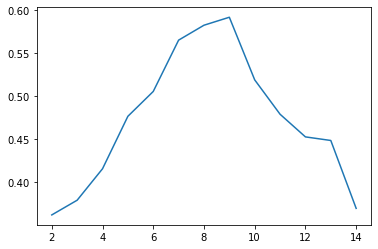

In [27]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl


scores = {i:-1 for i in range(2,15)}

for i in range(2,15):
    #calculate silhouette score between 2 and 15 clusters
    kmeans = KMeans(n_clusters=i,random_state=0).fit(Chicago_grouped_clustering)
    pred = kmeans.predict(Chicago_grouped_clustering)
    sil = silhouette_score(Chicago_grouped_clustering,pred)
    scores[i] = sil

#find the maximum silhouette score to identify the optimal k
scores_list = list(scores.values())
max_score = max(scores_list)
starting_k = 2
best_k = scores_list.index(max_score)+starting_k
plt.plot([i for i in range(2,15)],list(scores.values()))

In [28]:
# run k-means clustering
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(Chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 1, 1, 4, 4, 4, 0, 2])

###  Geographical coordinates of Chicago

In [29]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_

# merge latitude, longitude with most common venues per community
Chicago_merged_df = Chicago_merged_df.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Community Area')

#merge most common venues with eatery and shop scores
final = pd.merge(Chicago_merged_df,Score[['Community Area','Eatery score','Shop score']],on='Community Area')

#calculate total score by adding all scores
final['Total score'] = final[['Crime Score','Eatery score','Shop score']].sum(axis=1)
final.head()

,Community Area,Community Name,Latitude,Longitude,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
0,1,Rogers Park,42.009120,-87.668648,3080,0,Mexican Restaurant,American Restaurant,Bakery,Asian Restaurant,Pizza Place,Bar,Theater,Farmers Market,Sandwich Place,Sushi Restaurant,4.0,1,1,2
1,2,West Ridge,41.999316,-87.692394,2878,0,Indian Restaurant,Pakistani Restaurant,Grocery Store,Athletics & Sports,Donut Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Burmese Restaurant,Football Stadium,4.0,1,1,2
2,3,Uptown,41.966222,-87.658792,2746,0,Coffee Shop,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bar,Sushi Restaurant,Diner,Thai Restaurant,Sandwich Place,Discount Store,4.0,1,1,2
3,4,Lincoln Square,41.968844,-87.685397,1751,1,Bar,Sandwich Place,Café,Thai Restaurant,Mobile Phone Shop,Sushi Restaurant,Chinese Restaurant,Art Gallery,Pharmacy,American Restaurant,1.0,1,1,3
4,5,North Center,41.950503,-87.681029,1055,1,Bar,Pub,Boutique,Coffee Shop,Mobile Phone Shop,Diner,Bakery,Chinese Restaurant,Music Venue,Dance Studio,1.0,1,1,3


In [30]:
best_k

9

In [31]:
address = 'Chicago, USA'

geolocator = Nominatim(user_agent="Chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


### Create a map of Chicago with neighborhoods

In [98]:
# create map of Toronto using latitude and longitude values
map_Chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final['Latitude'], final['Longitude'], final['Community Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Chicago)  
    
map_Chicago

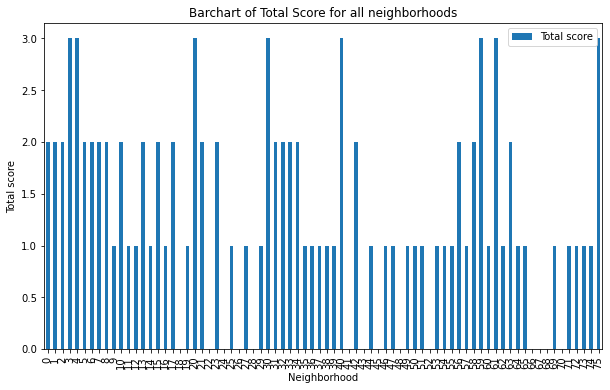

In [33]:
final[['Community Name','Total score']].plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Total score') # add y-label to the plot
plt.title('Barchart of Total Score for all neighborhoods') # add title to the plot

plt.show()

### Analyze by cluster


### Examine Cluster 1

In [70]:
final.head()

,Community Area,Community Name,Latitude,Longitude,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
0,1,Rogers Park,42.009120,-87.668648,3080,0,Mexican Restaurant,American Restaurant,Bakery,Asian Restaurant,Pizza Place,Bar,Theater,Farmers Market,Sandwich Place,Sushi Restaurant,4.0,1,1,2
1,2,West Ridge,41.999316,-87.692394,2878,0,Indian Restaurant,Pakistani Restaurant,Grocery Store,Athletics & Sports,Donut Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Burmese Restaurant,Football Stadium,4.0,1,1,2
2,3,Uptown,41.966222,-87.658792,2746,0,Coffee Shop,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bar,Sushi Restaurant,Diner,Thai Restaurant,Sandwich Place,Discount Store,4.0,1,1,2
3,4,Lincoln Square,41.968844,-87.685397,1751,1,Bar,Sandwich Place,Café,Thai Restaurant,Mobile Phone Shop,Sushi Restaurant,Chinese Restaurant,Art Gallery,Pharmacy,American Restaurant,1.0,1,1,3
4,5,North Center,41.950503,-87.681029,1055,1,Bar,Pub,Boutique,Coffee Shop,Mobile Phone Shop,Diner,Bakery,Chinese Restaurant,Music Venue,Dance Studio,1.0,1,1,3


In [35]:
cluster_1 = final.loc[final['Cluster Labels'] == 0, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_1

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
8,Edison Park,229,1,Bar,Italian Restaurant,Mexican Restaurant,Theater,Track,Grocery Store,French Restaurant,Salon / Barbershop,Pub,Spa,0.0,1,0,2
13,Albany Park,1901,1,Mexican Restaurant,Korean Restaurant,Grocery Store,Park,Asian Restaurant,Latin American Restaurant,Sushi Restaurant,Liquor Store,Taco Place,Karaoke Bar,0.0,1,0,2
15,Irving Park,2044,1,Bar,Dance Studio,American Restaurant,Asian Restaurant,Moroccan Restaurant,Latin American Restaurant,Furniture / Home Store,Supermarket,Breakfast Spot,Bus Station,0.0,1,0,2
32,Near South Side,1477,1,Football Stadium,Athletics & Sports,Historic Site,Park,Bakery,New American Restaurant,Bar,Salon / Barbershop,Cocktail Bar,Sushi Restaurant,0.0,1,0,2
33,Armour Square,797,1,Chinese Restaurant,Pizza Place,Mexican Restaurant,Asian Restaurant,Szechuan Restaurant,Business Service,Park,Storage Facility,Mobile Phone Shop,Flea Market,0.0,1,0,2
34,Douglas,2026,1,Fast Food Restaurant,Fried Chicken Joint,Wings Joint,Cosmetics Shop,Sandwich Place,Mobile Phone Shop,Residential Building (Apartment / Condo),Liquor Store,Eye Doctor,Bank,0.0,1,0,2


In [36]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(final[final['Cluster Labels']==0]['Total crimes'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

[1 0 0 1 0 0 1 0 0 3]
[ 229.   410.5  592.   773.5  955.  1136.5 1318.  1499.5 1681.  1862.5
 2044. ]
Matplotlib version:  3.2.2


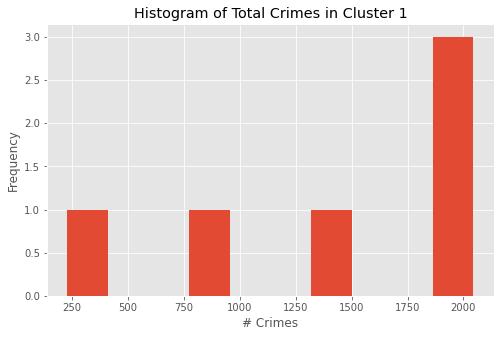

In [37]:
#cluster_1 = final[final['Cluster Labels']==0]
cluster_1['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 1') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

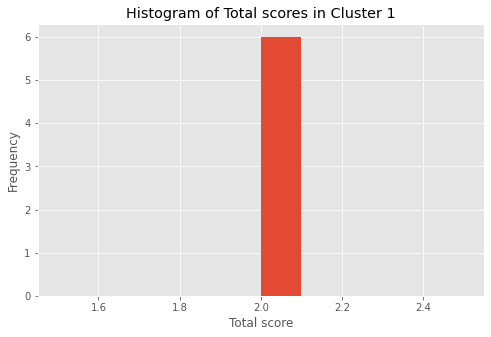

In [38]:
cluster_1['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 1') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 2

In [39]:
cluster_2 = final.loc[final['Cluster Labels'] == 1, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_2

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
3,Lincoln Square,1751,1,Bar,Sandwich Place,Café,Thai Restaurant,Mobile Phone Shop,Sushi Restaurant,Chinese Restaurant,Art Gallery,Pharmacy,American Restaurant,1.0,1,1,3
4,North Center,1055,1,Bar,Pub,Boutique,Coffee Shop,Mobile Phone Shop,Diner,Bakery,Chinese Restaurant,Music Venue,Dance Studio,1.0,1,1,3
20,Avondale,1689,1,Park,Hot Dog Joint,Bar,Chinese Restaurant,Mexican Restaurant,Breakfast Spot,ATM,Food Truck,Korean Restaurant,Supermarket,1.0,1,1,3
30,Lower West Side,1906,1,Mexican Restaurant,Pizza Place,Bakery,Thrift / Vintage Store,Latin American Restaurant,Bar,Plaza,Taco Place,Breakfast Spot,Massage Studio,1.0,1,1,3
40,Hyde Park,1376,1,Sandwich Place,Mobile Phone Shop,Thai Restaurant,Café,Pizza Place,American Restaurant,Cosmetics Shop,Ice Cream Shop,Bookstore,Coffee Shop,1.0,1,1,3
59,Bridgeport,1180,1,Chinese Restaurant,Bar,Pizza Place,Mexican Restaurant,American Restaurant,Grocery Store,Wings Joint,Korean Restaurant,Bus Station,Coffee Shop,1.0,1,1,3
61,West Elsdon,676,1,Mexican Restaurant,Chinese Restaurant,Pizza Place,Seafood Restaurant,Supplement Shop,Supermarket,Donut Shop,Grocery Store,Fried Chicken Joint,Gas Station,1.0,1,1,3
75,Edgewater,2172,1,Asian Restaurant,Sushi Restaurant,Gym,Coffee Shop,Bank,Sandwich Place,Indian Restaurant,Liquor Store,Bus Station,Gym / Fitness Center,1.0,1,1,3


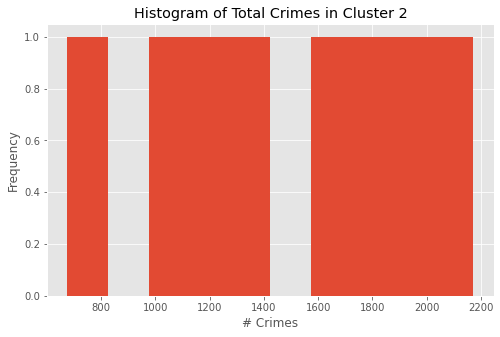

In [40]:
cluster_2['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 2') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

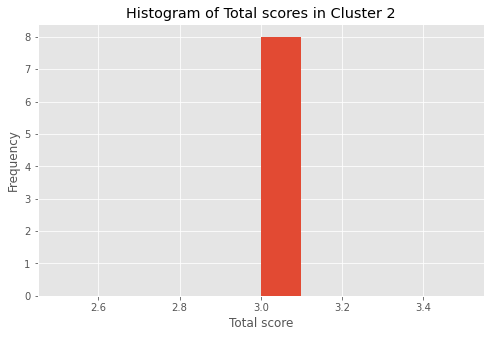

In [41]:
cluster_2['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 2') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 3

In [42]:
cluster_3 = final.loc[final['Cluster Labels'] == 2, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_3

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
9,Norwood Park,893,1,Train Station,Sandwich Place,Hobby Shop,Spa,Gastropub,American Restaurant,Automotive Shop,Italian Restaurant,Thai Restaurant,Diner,2.0,0,0,1
11,Forest Glen,496,1,Other Great Outdoors,Playground,Soccer Field,Golf Course,Yoga Studio,Fast Food Restaurant,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,2.0,0,0,1
12,North Park,720,1,Korean Restaurant,Coffee Shop,Convenience Store,College Quad,Food Truck,Pizza Place,Bus Station,Sandwich Place,Taco Place,Bakery,2.0,0,0,1
14,Portage Park,2430,1,Mexican Restaurant,Pizza Place,Playground,Sports Bar,Dog Run,Rental Car Location,Coffee Shop,Park,Track,Farmers Market,2.0,0,0,1
16,Dunning,1229,1,Thai Restaurant,Polish Restaurant,Pet Store,Tattoo Parlor,Fast Food Restaurant,Asian Restaurant,Japanese Restaurant,Gym Pool,Deli / Bodega,Spa,2.0,0,0,1
19,Hermosa,1107,1,Mexican Restaurant,Ice Cream Shop,Park,Clothing Store,Bakery,BBQ Joint,Latin American Restaurant,Grocery Store,Greek Restaurant,Insurance Office,2.0,0,0,1
35,Oakland,575,1,Beach,Trail,Hotel,Vineyard,Dog Run,Juice Bar,Track,Park,Yoga Studio,Farm,2.0,0,0,1
36,Fuller Park,646,1,Bus Station,Restaurant,Health Food Store,Train Station,Fast Food Restaurant,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,2.0,0,0,1
38,Kenwood,1123,1,Gym / Fitness Center,Donut Shop,Art Gallery,Clothing Store,Liquor Store,Bank,Chinese Restaurant,Boutique,Other Great Outdoors,Tennis Court,2.0,0,0,1
39,Washington Park,1834,1,Fast Food Restaurant,Breakfast Spot,Gas Station,Theater,Nature Preserve,Lounge,Bus Station,Art Gallery,Train Station,Farmers Market,2.0,0,0,1


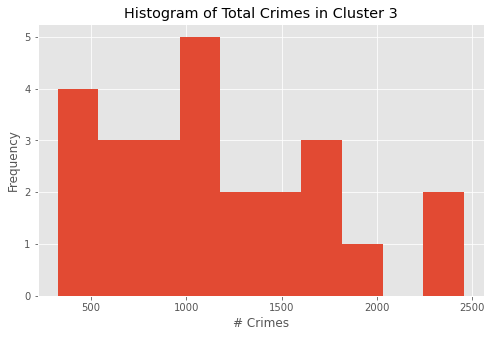

In [43]:
cluster_3['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 3') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

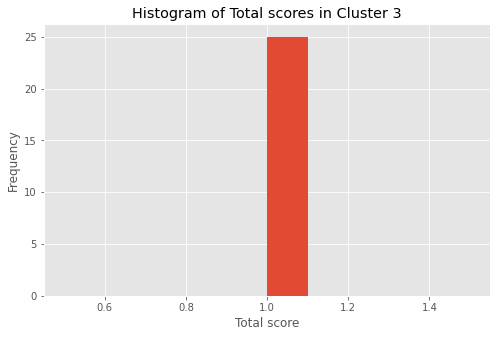

In [44]:
cluster_3['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 3') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 4

In [45]:
cluster_4 = final.loc[final['Cluster Labels'] == 3, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_4

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
18,Belmont Cragin,3502,0,Mexican Restaurant,Convenience Store,Donut Shop,Ice Cream Shop,American Restaurant,Grocery Store,Athletics & Sports,Sandwich Place,Supermarket,Field,3.0,0,0,0
22,Humboldt Park,6278,0,Park,Liquor Store,Taco Place,Donut Shop,Grocery Store,Video Store,Art Gallery,Event Service,Yoga Studio,Farm,3.0,0,0,0
24,Austin,11928,0,Discount Store,Cosmetics Shop,Breakfast Spot,Pizza Place,Salon / Barbershop,Café,Field,Farm,Farmers Market,Fast Food Restaurant,3.0,0,0,0
26,East Garfield Park,3534,0,Discount Store,Diner,Bus Station,Bus Line,Supermarket,Liquor Store,Pharmacy,Southern / Soul Food Restaurant,Floating Market,Flea Market,3.0,0,0,0
28,North Lawndale,6675,0,Fast Food Restaurant,BBQ Joint,Convenience Store,Yoga Studio,Food Court,Food & Drink Shop,Food,Flower Shop,Floating Market,Flea Market,3.0,0,0,0
41,Woodlawn,2720,0,History Museum,Coffee Shop,Bookstore,Indie Movie Theater,Pub,Café,Market,College Cafeteria,Park,Sandwich Place,3.0,0,0,0
43,Chatham,5139,0,Park,Boutique,Lounge,Discount Store,Donut Shop,Fast Food Restaurant,Food,Fried Chicken Joint,Ice Cream Shop,Hardware Store,3.0,0,0,0
45,South Chicago,3168,0,Park,Mexican Restaurant,Pizza Place,American Restaurant,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,3.0,0,0,0
48,Roseland,5600,0,Sandwich Place,Intersection,BBQ Joint,Fast Food Restaurant,Event Service,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,3.0,0,0,0
52,West Pullman,3628,0,Convenience Store,Grocery Store,Bar,Yoga Studio,Filipino Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,3.0,0,0,0


In [46]:
cluster_4.shape

(14, 17)

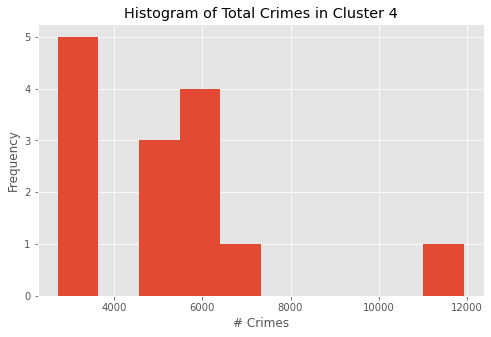

In [47]:
cluster_4['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 4') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

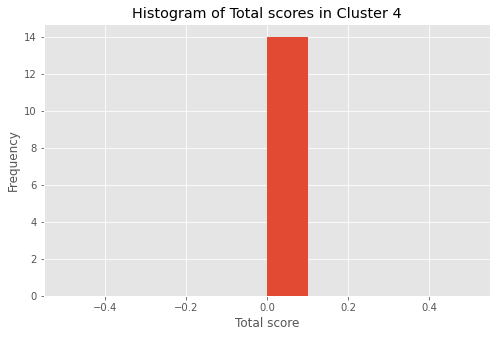

In [48]:
cluster_4['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 4') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 5

In [49]:
cluster_5 = final.loc[final['Cluster Labels'] == 4, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_5

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
0,Rogers Park,3080,0,Mexican Restaurant,American Restaurant,Bakery,Asian Restaurant,Pizza Place,Bar,Theater,Farmers Market,Sandwich Place,Sushi Restaurant,4.0,1,1,2
1,West Ridge,2878,0,Indian Restaurant,Pakistani Restaurant,Grocery Store,Athletics & Sports,Donut Shop,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Burmese Restaurant,Football Stadium,4.0,1,1,2
2,Uptown,2746,0,Coffee Shop,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bar,Sushi Restaurant,Diner,Thai Restaurant,Sandwich Place,Discount Store,4.0,1,1,2
5,Lake View,4007,0,Sandwich Place,Pizza Place,Coffee Shop,Bagel Shop,Bakery,Bar,Performing Arts Venue,Spa,Café,Pub,4.0,1,1,2
6,Lincoln Park,2642,0,Bar,Coffee Shop,Pizza Place,Sandwich Place,Yoga Studio,Mexican Restaurant,Theater,Taco Place,Ice Cream Shop,Hot Dog Joint,4.0,1,1,2
7,Near North Side,6859,0,Hotel,Steakhouse,Bar,Italian Restaurant,Clothing Store,Boutique,Coffee Shop,Gym / Fitness Center,American Restaurant,Lounge,4.0,1,1,2
21,Logan Square,3480,0,Cocktail Bar,Bar,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Café,Yoga Studio,Bike Shop,Bowling Alley,4.0,1,1,2
23,West Town,4957,0,Bar,Café,Salon / Barbershop,Pizza Place,Sushi Restaurant,Bakery,Argentinian Restaurant,Pet Store,Cocktail Bar,Italian Restaurant,4.0,1,1,2
31,Loop,4843,0,Coffee Shop,American Restaurant,Hotel,Theater,Bakery,Museum,Snack Place,Department Store,Plaza,Bar,4.0,1,1,2
42,South Shore,7320,0,Grocery Store,Pizza Place,Cosmetics Shop,American Restaurant,Currency Exchange,Bus Station,Seafood Restaurant,Pharmacy,Sandwich Place,Fried Chicken Joint,4.0,1,1,2


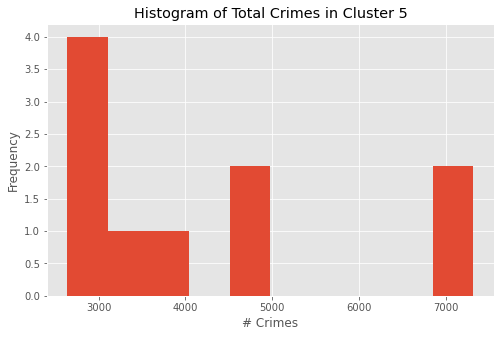

In [50]:
cluster_5['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 5') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

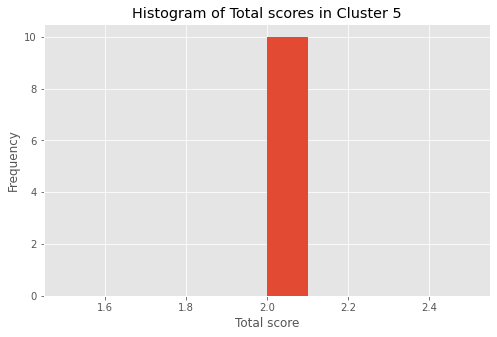

In [51]:
cluster_5['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 5') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 6

In [52]:
cluster_6 = final.loc[final['Cluster Labels'] == 5, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_6

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
10,Jefferson Park,884,1,Discount Store,Chinese Restaurant,Mobile Phone Shop,Bar,Market,Automotive Shop,Greek Restaurant,Sandwich Place,Dive Bar,Bowling Alley,5.0,0,1,2
17,Montclare,525,1,Mexican Restaurant,Furniture / Home Store,Bus Station,Pizza Place,Breakfast Spot,Café,Other Repair Shop,Electronics Store,Automotive Shop,Grocery Store,5.0,0,1,2
56,Archer Heights,656,1,Mexican Restaurant,Discount Store,Sandwich Place,Bank,Shopping Mall,Shoe Store,Seafood Restaurant,Mobile Phone Shop,Supplement Shop,Rental Car Location,5.0,0,1,2
58,McKinley Park,697,1,Mexican Restaurant,Video Store,Thrift / Vintage Store,Diner,Grocery Store,Baseball Field,Supermarket,Soccer Field,Donut Shop,Bus Station,5.0,0,1,2
63,Clearing,772,1,Construction & Landscaping,Pizza Place,Video Store,Playground,Donut Shop,Discount Store,Record Shop,Grocery Store,Fast Food Restaurant,Chinese Restaurant,5.0,0,1,2


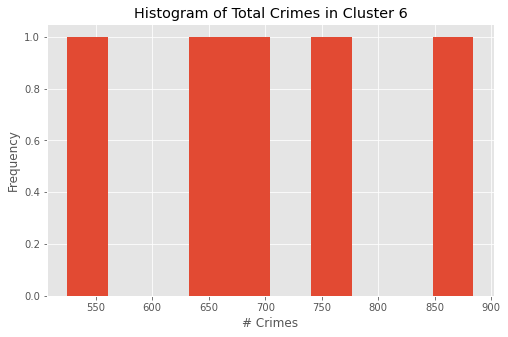

In [53]:
cluster_6['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 6') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

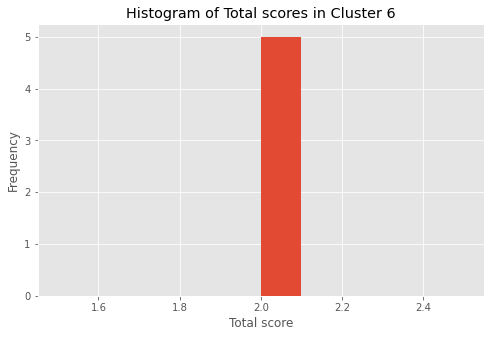

In [54]:
cluster_6['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 6') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 7

In [55]:
cluster_7 = final.loc[final['Cluster Labels'] == 6, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_7

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
25,West Garfield Park,4681,0,Fast Food Restaurant,Shoe Store,Fried Chicken Joint,Clothing Store,Liquor Store,Caribbean Restaurant,Mobile Phone Shop,Kids Store,Supermarket,Sandwich Place,6.0,0,1,1
27,Near West Side,6072,0,Park,Café,Dance Studio,Coffee Shop,Bar,Yoga Studio,College Stadium,Bus Station,Sports Bar,Stadium,6.0,0,1,1
29,South Lawndale,3354,0,Mexican Restaurant,Mobile Phone Shop,Park,Food & Drink Shop,Supermarket,Liquor Store,Optical Shop,Bakery,Restaurant,Grocery Store,6.0,0,1,1
37,Grand Boulevard,2757,0,Liquor Store,Art Gallery,Cosmetics Shop,BBQ Joint,Burger Joint,Shoe Store,Breakfast Spot,Caribbean Restaurant,Sandwich Place,Lounge,6.0,0,1,1
60,New City,3373,0,Pizza Place,Grocery Store,Bank,Brewery,Mexican Restaurant,Department Store,Pharmacy,Shoe Store,Farm,Chinese Restaurant,6.0,0,1,1


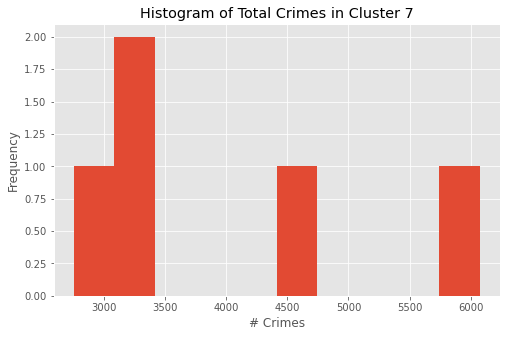

In [56]:
cluster_7['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 7') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

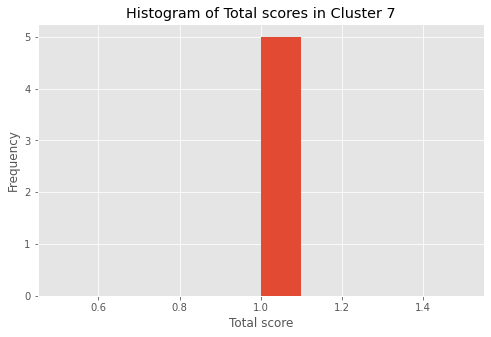

In [57]:
cluster_7['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 7') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 8

In [58]:
cluster_8 = final.loc[final['Cluster Labels'] == 7, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_8

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
50,South Deering,1544,1,Park,Yoga Studio,Event Service,Food Court,Food & Drink Shop,Food,Flower Shop,Floating Market,Flea Market,Filipino Restaurant,7.0,0,0,1
53,Riverdale,1003,1,Park,Yoga Studio,Event Service,Food Court,Food & Drink Shop,Food,Flower Shop,Floating Market,Flea Market,Filipino Restaurant,7.0,0,0,1


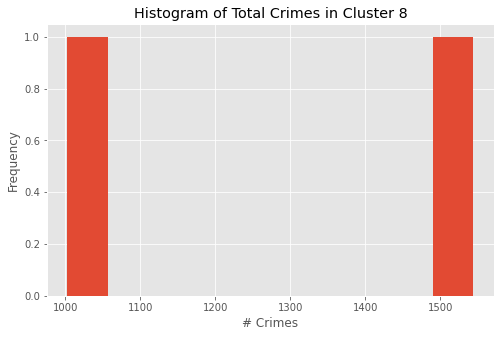

In [59]:
cluster_8['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 8') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

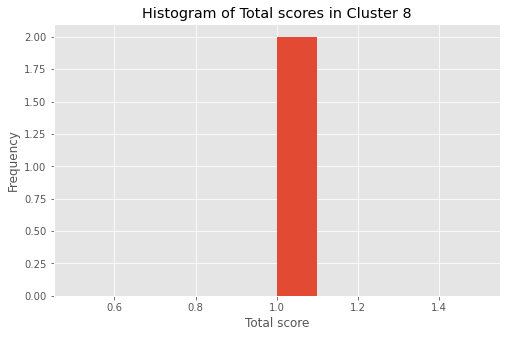

In [60]:
cluster_8['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 8') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Examine Cluster 9

In [61]:
final[final['Community Area']==72]

,Community Area,Community Name,Latitude,Longitude,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score


In [62]:
cluster_9 = final.loc[final['Cluster Labels'] == 8, final.columns[[1] + list(range(4, final.shape[1]))]]
cluster_9

,Community Name,Total crimes,Crime Score,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Eatery score,Shop score,Total score
65,Chicago Lawn,4581,0,Mexican Restaurant,Pizza Place,Cosmetics Shop,Fast Food Restaurant,Intersection,American Restaurant,Flea Market,Farm,Farmers Market,Field,8.0,1,0,1


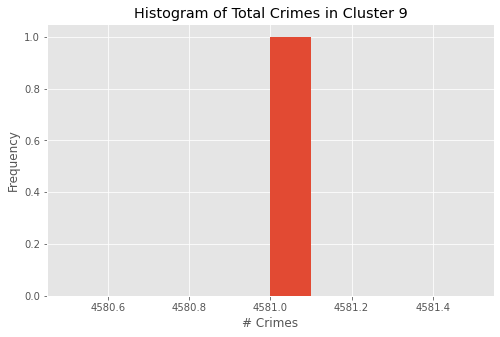

In [63]:
cluster_9['Total crimes'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total Crimes in Cluster 9') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('# Crimes') # add x-label

plt.show()

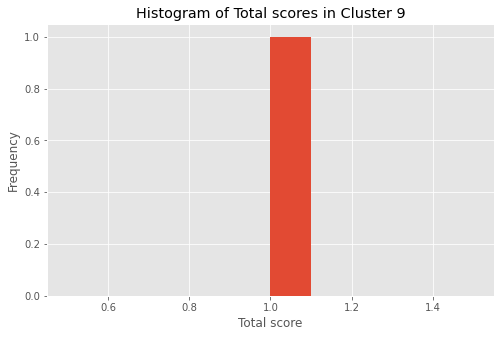

In [64]:
cluster_9['Total score'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Total scores in Cluster 9') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Total score') # add x-label

plt.show()

### Total crimes per cluster

In [71]:
group_crimes = final.groupby(['Cluster Labels'])['Total crimes'].sum()
group_crimes

Cluster Labels
0.0     8474
1.0    11805
2.0    29071
3.0    73846
4.0    42812
5.0     3534
6.0    20237
7.0     2547
8.0     4581
Name: Total crimes, dtype: int64

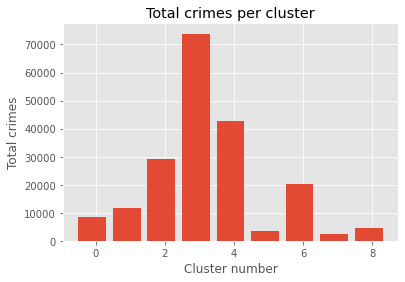

In [67]:
x = np.arange(len(group_crimes))
plt.bar(x-0.1,group_crimes)
plt.ylabel('Total crimes')
plt.xlabel('Cluster number')
plt.title('Total crimes per cluster')
plt.show()

### Total score per cluster

In [72]:
group_mean = final.groupby(['Cluster Labels'])['Total score'].mean()
group_mean

Cluster Labels
0.0    2
1.0    3
2.0    1
3.0    0
4.0    2
5.0    2
6.0    1
7.0    1
8.0    1
Name: Total score, dtype: int64

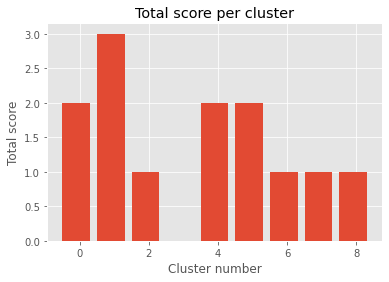

In [69]:
x = np.arange(len(group_mean))
plt.bar(x-0.1,group_mean)
plt.ylabel('Total score')
plt.xlabel('Cluster number')
plt.title('Total score per cluster')
plt.show()